In [1]:
import os
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt 

# Loading Data and Data Exploration

## Dataset overview
    This dataset i brought from this repo https://github.com/SullyChen/driving-datasets
    Dataset contains Approximately 45,500 images, 2.2GB. it was made in 2017.
    Data was recorded around Rancho Palos Verdes and San Pedro California using a car dashcam 
    with steering wheel angle as label

In [3]:
datalabels=open('driving_dataset/data.txt','r')

In [4]:
# this text contains the name of each image and its label as follows : imagename angle 
# so i will put angles (Y) on list and names on other list to explore make it easier for myself to explore data 

imagenames=[]
Y=[]
for line in datalabels:
    l=line.split()
    imagenames.append('driving_dataset/'+l[0])
    Y.append(float(l[1]))

## Data exploration

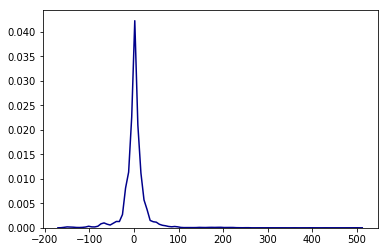

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(Y, hist=False, kde=True,  color = 'darkblue')


- since while you drive most of the roads are straight forward or have little curves therfore the data has most labels around  0->50 degree 
- so what we can do is we can augment with flipping technique the images with angle bigger than 40

In [37]:
imageshape=np.shape(cv2.imread(imagenames[0]))
print("Each image in the dataset is an RGB image with shape {}".format(imageshape))

Each image in the dataset is an RGB image with shape (256, 455, 3)


# Data Augmentation

## Flipping

In [6]:
datalabels=open('driving_dataset/data.txt','a')

count=45568
augcount=0
for i in range(len(Y)):
    if (Y[i]>40.0):
        image=cv2.imread(imagenames[i])
        newimg=cv2.flip(image,1)
        newangle=0-Y[i]
        newname=str(count)+'.jpg'
        Y.append(newangle)
        imagenames.append('driving_dataset/'+newname)
        cv2.imwrite('driving_dataset/'+newname,newimg)
        datalabels.write(newname+' '+str(newangle)+'\n')
        count+=1
        augcount+=1

In [7]:

augcount=0
for i in range(len(Y)):
    if (Y[i]<-55.0):
        image=cv2.imread(imagenames[i])
        newimg=cv2.flip(image,1)
        newangle=0-Y[i]
        newname=str(count)+'.jpg'
        Y.append(newangle)
        imagenames.append('driving_dataset/'+newname)
        cv2.imwrite('driving_dataset/'+newname,newimg)

        datalabels.write(newname+' '+str(newangle)+'\n')
        count+=1
        augcount+=1

In [8]:
print("Number of images now is %d" %count)

#data will be splitted into  80 : 10 : 10
# so training data will be 42908
# validation will be 5363
# testing will be the left 5364

Number of images now is 50191


# Preprocessing and splitting data

In [17]:


from scipy import pi

# #as the labels are in degrees we want it in radians as the tensorflow activation function atan returns it in radian

for i in range(len(Y)):
    Y[i]=Y[i]*pi/180

In [9]:
# here i will build 3 functions for preprocessing and splitting the data 
# first i will shuffle data
# each image will be cropped and normalizedso that the upper part of it is cropped as it contains the sky and it
# has nothing to do with prediction
#first 2 functions generate each set as 2 numpy arrays one for images and one for labels 
# while third function is a generator function that will be used in training as the training set is very big to be 
# loaded at once so it willl be loaded in batches 
import numpy as np
from scipy.misc import imread, imresize
import os
import scipy.io as io

batch_pointer=0

    
def get_val_data(X,y):
    X_test=X[40152:45171]        
    #here we take the 150 rows of pixels from the lower part of images only as they contain road details 
    #and then resize the image to (66,200,3) as in Pilotnet architecture in NVIDIA's paper (END TO END LEARNING FOR SELF-DRIVING CARS)
    images = np.array([np.float32(imresize(imread(im)[-150:], size=(66, 200))) /255 for im in X_test])
    return np.array(images),np.array(y[40152:45171])

def get_test_data(X,y):
    X_test=X[45171:]
    images = np.array([np.float32(imresize(imread(im)[-150:], size=(66, 200))) /255 for im in X_test])
    return np.array(images),np.array(y[45171:])

#this is a generator function that generates batches of images while training the model 
def generate_arrays_from_file():
    global batch_pointer
    batch_size=64
    train_data=40152

    while True:
        batch_start=batch_pointer%train_data
        batch_end=(batch_pointer+batch_size)%train_data
        if (batch_end<batch_start):
            batch_end=train_data
        X_batch=imagenames[batch_start:batch_end]
        images = np.array([np.float32(imresize(imread(im)[-150:], size=(66, 200))) /255 for im in X_batch])

        y_batch = Y[batch_start:batch_end]
        batch_pointer+=batch_size
        batch_pointer%=train_data

        yield np.array(images),np.array(y_batch)


In [47]:

from sklearn.utils import shuffle

imagenames,Y=shuffle(imagenames,Y)
val_X,val_y=get_val_data(imagenames,Y)
val_set=(val_X,val_y)

test_X,test_y=get_test_data(imagenames,Y)

/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


### Plotting samples from dataset before and after processing

/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


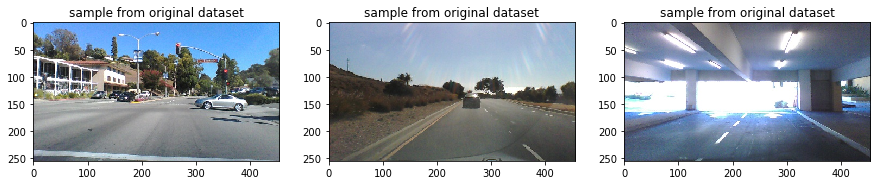

In [34]:
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.title('sample from original dataset')
    ax.imshow(imread(imagenames[3212*i]))
plt.show()

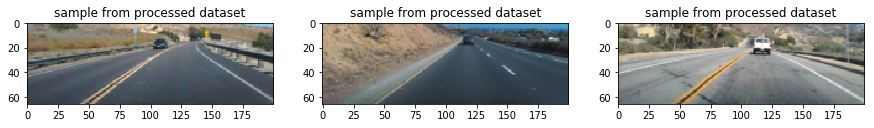

In [35]:
fig = plt.figure(1,figsize=(15,15))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    plt.title('sample from processed dataset')
    ax.imshow(val_X[i])
plt.show()

In [43]:
imageshape=np.shape(val_X[0])
print("Image after processing is an RGB image with shape {}".format(imageshape))
print("Valid set size is {}".format(len(val_X)))
print("Test set size is {}".format(len(test_X)))

Image after processing is an RGB image with shape (66, 200, 3)
Valid set size is 5019
Test set size is 4858


# Defining and training benchmark naive model 

In [13]:
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation,Dropout,Lambda
from keras.layers.core import Dense,Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.initializers import TruncatedNormal,Constant
from keras.regularizers import l2

Using TensorFlow backend.


In [26]:

def get_naive_model():
    model=Sequential()
    model.add(Conv2D(2,(5,5),strides=(2,2),activation='relu',input_shape=(66,200,3)))
    model.add(Conv2D(2,(5,5),strides=(2,2),activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=15,activation='relu'))
    model.add(Dense(units=1,kernel_initializer=TruncatedNormal(stddev=30),bias_initializer=Constant(value=0.1),input_dim=10))
  
    return model
    

In [31]:
naive_model=get_naive_model()
naive_model.summary()
naive_model.compile(optimizer=Adam(epsilon=1e-08,lr=0.001), loss='mse',metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 98, 2)         152       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 47, 2)         102       
_________________________________________________________________
flatten_4 (Flatten)          (None, 1316)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                19755     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 16        
Total params: 20,025
Trainable params: 20,025
Non-trainable params: 0
_________________________________________________________________


## training the benchmark naive model

In [32]:

history=naive_model.fit_generator(generate_arrays_from_file(), steps_per_epoch=5, epochs=1,verbose=1,validation_data=val_set)


Epoch 1/1


/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


5/5 [==============================] - 5s 926ms/step - loss: 23.1425 - mean_squared_error: 23.1425 - val_loss: 41.7076 - val_mean_squared_error: 41.7076


In [34]:

loss,acc=naive_model.evaluate(test_X, test_y, batch_size=50)
print('test_loss is %f'%loss)

2846/2846 [==============================] - 0s 139us/step
test_loss is 6.353388


# Defining and Training Pilotnet architecture from scratch 

In [21]:
def atan_layer(x):
    return tf.multiply(tf.atan(x), 2)

def atan_layer_shape(input_shape):
    return input_shape

def getmodel():
    model=Sequential()
    model.add(Conv2D(24,(5,5),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(66,200,3),use_bias=True))
    model.add(Conv2D(36,(5,5),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(31,98,24),use_bias=True))
    model.add(Conv2D(48,(5,5),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(14,47,36),use_bias=True))
    model.add(Conv2D(64,(3,3),strides=(1,1),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(5,22,48),use_bias=True))
    model.add(Conv2D(64,(3,3),strides=(1,1),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(1,18,64),use_bias=True))
    model.add(Flatten())
    model.add(Dense(units=1164,kernel_initializer=TruncatedNormal(stddev=0.1),activation='elu',input_dim=1152))
    #model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=100,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=1164))
    #model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=50,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=100))
    #model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=10,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=50))
    #model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),input_dim=10))
  
    model.add(Lambda(atan_layer, output_shape = atan_layer_shape, name = "atan_0"))
    return model

In [26]:
model =getmodel ()
model.summary()
model.compile(optimizer=Adam(epsilon=1e-08,lr=0.001), loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1164)              1342092   
__________

In [27]:
history=model.fit_generator(generate_arrays_from_file(), steps_per_epoch=670, epochs=8,verbose=1,validation_data=val_set)

Epoch 1/8


/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ahmad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


670/670 [==============================] - 76s 114ms/step - loss: 0.6168 - val_loss: 0.6646
Epoch 2/8
670/670 [==============================] - 76s 113ms/step - loss: 0.4132 - val_loss: 0.3554
Epoch 3/8
670/670 [==============================] - 76s 113ms/step - loss: 0.2252 - val_loss: 0.1515
Epoch 4/8
670/670 [==============================] - 76s 113ms/step - loss: 0.1254 - val_loss: 0.0985
Epoch 5/8
670/670 [==============================] - 76s 113ms/step - loss: 0.1966 - val_loss: 0.3110
Epoch 6/8
670/670 [==============================] - 76s 114ms/step - loss: 0.1284 - val_loss: 0.0890
Epoch 7/8
670/670 [==============================] - 76s 113ms/step - loss: 0.0815 - val_loss: 0.0945
Epoch 8/8
670/670 [==============================] - 77s 115ms/step - loss: 0.0739 - val_loss: 0.0760


## Plotting learning curve

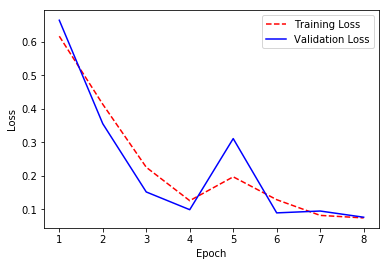

In [28]:

training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [30]:

loss=model.evaluate(test_X, test_y, batch_size=50)
print('robust model test_loss is %f'%loss)

4858/4858 [==============================] - 1s 212us/step
robust model test_loss is 0.045240


# Conclusion

- Benchmark naive cnn got 6.353388 Mean-Squared error while My more robust cnn reach 0.045 on testing 
- reaching this error rate seems to confirm that End to End deep learning is a suitable solution for the problem